# Exercise 2

In [3]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import fminbound
from scipy.stats import lognorm

# to print plots inline
%matplotlib inline

In [4]:
γ = 0.5
β = 0.96
δ = 0.05
α = 0.4
σ_z = 0.2

In [5]:
def utility(k, kprime, z_expected, γ, α, δ):
    C = (1 - δ) * k + z_expected * k ** α - kprime
    U = (C ** (1 - γ)) / (1 - γ)
    return U

In [6]:
'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = 0.4
ub_k = 100
size_k = 200  # Number of grid points
k_grid = np.linspace(lb_k, ub_k, size_k)

In [17]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption 
U        = matrix, current period utility value for all possible
           choices of k and k'
------------------------------------------------------------------------
'''
N = 10000 # number of random draws
z = lognorm.rvs(s=σ_z, size=N)
z_expected = z.mean()

In [18]:
# write Bellman operator function to help with VFI
def bellman_operator(V, k_grid, β, z_expected, γ, α, δ):
    '''
    The approximate Bellman operator, which computes and returns the
    updated value function TV on the grid points.  An array to store
    the new set of values TV is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.
    '''
    
    # Apply cubic interpolation to V
    V_func = interpolate.interp1d(k_grid, V, kind='cubic', fill_value='extrapolate')

    # Initialize array for operator and policy function
    TV = np.empty_like(V)
    optK = np.empty_like(TV)

    # == set TV[i] = max_w' { u(w,w') + beta V(w')} == #
    for i, k in enumerate(k_grid):
        def objective(kprime):
            return - utility(k, kprime, z_expected, γ, α, δ) - β * V_func(kprime)
        kprime_star = fminbound(objective, 1e-6, k - 1e-6)
        optK[i] = kprime_star
        TV[i] = - objective(kprime_star)
    return TV, optK

In [19]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of w and w'
VFiter    = integer, current iteration number
V_params  = tuple, contains parameters to pass into Belman operator: beta, sigma
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of w' for all w 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-5
VFdist = 7.0 
VFmaxiter = 500 
V = np.zeros(size_k)#true_VF # initial guess at value function
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    TV, optK = bellman_operator(V, k_grid, β, z_expected, γ, α, δ)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 308


In [20]:
optC = k_grid * (1 - δ) + z_expected * k_grid ** α - optK

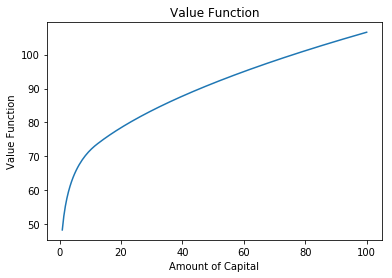

In [29]:
# Plot value function 
plt.figure()
plt.plot(k_grid[1:], VF[1:])
plt.xlabel('Amount of Capital')
plt.ylabel('Value Function')
plt.title('Value Function')
plt.show()

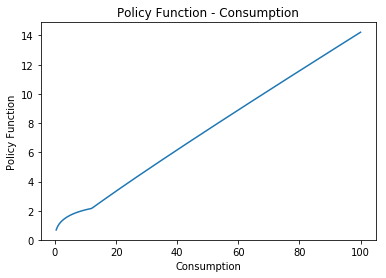

In [30]:
plt.plot(k_grid, optC)
plt.xlabel('Consumption')
plt.ylabel('Policy Function')
plt.title('Policy Function - Consumption')
plt.show()

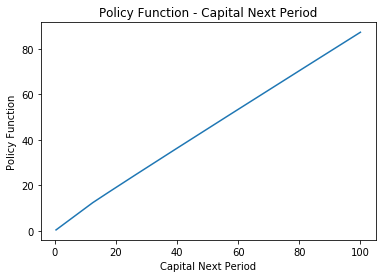

In [32]:
plt.plot(k_grid, optK)
plt.xlabel('Capital Next Period')
plt.ylabel('Policy Function')
plt.title('Policy Function - Capital Next Period')
plt.show()